In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def createSequnces(dataset, lookback=10):
    """Transform a continuous data sequence to 
    dataX in shape (num_instances, lookback, num_features)
    and dataY in shape (num_instances, num_features)"""
    data = dataset.values
    dataX, dataY = [], []
    for i in range(len(data)-lookback):
        x = data[i:(i+lookback)]
        dataX.append(x)
        y = data[i+lookback]
        dataY.append(y)
    return dataX, dataY

def getBrokens(indice):
    """Get the broken positions of a discontinuous sequnence"""
    broken_points = [0]
    for i, ts in enumerate(indice):
        if ts+1 not in indice:
            broken_points.append(i+1)
    return broken_points

def createDataset(dataset, lookback):
    """Divide a discountinuous sequence into several continuous sequences 
    and transform each of them to dataX and dataY form,
    then concatenate all together"""
    X, Y = [], []
    broken_points = getBrokens(dataset.index)
    for i in range(len(broken_points)-1):
        x, y = createSequnces(dataset.iloc[broken_points[i]:broken_points[i+1], :], lookback)
        X += x
        Y += y
    return np.array(X), np.array(Y)

In [3]:
train = pd.read_csv('../train_treated.csv', index_col=0)
val = pd.read_csv('../val1_treated.csv', index_col=0)

In [4]:
from keras.models import Sequential  
from keras.layers.core import Dense  
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

/home/sven/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# grid search

In [6]:
lookbacks = [1, 2, 10]
hiddens = [100, 200, 300]

bm = pd.DataFrame(columns = ['lookback', 'hidden_neurons', 'train_loss', 'val_loss'])

count = 0
for lookback in lookbacks:
    trainX, trainY = createDataset(train, lookback)
    valX, valY = createDataset(val, lookback)
    
    for hidden in hiddens:
        print("\n\ntraining with {} lookback and {} hidden neurons\n\n".format(lookback, hidden))
        model = Sequential()  
        model.add(LSTM(hidden, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
        model.add(LSTM(trainY.shape[1]))
#         model.add(Dense(trainY.shape[1], activation='linear'))  
        model.compile(loss="mean_squared_error", optimizer="rmsprop")
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
        history = model.fit(trainX,
                            trainY,
                            batch_size=450,
                            epochs=100,
                            verbose=1,
                            validation_data=(valX, valY),
                            callbacks=[earlyStopping])
        bm.loc[count, :] = [lookback, hidden, history.history['loss'][-1], history.history['val_loss'][-1]]
        count += 1



training with 1 lookback and 100 hidden neurons


Train on 44831 samples, validate on 11198 samples
Epoch 1/100
44831/44831 [==============================] - 2s 51us/step - loss: 0.1077 - val_loss: 0.0397
Epoch 2/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0170 - val_loss: 0.0331
Epoch 3/100
44831/44831 [==============================] - 1s 22us/step - loss: 0.0103 - val_loss: 0.0272
Epoch 4/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0069 - val_loss: 0.0233
Epoch 5/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0048 - val_loss: 0.0202
Epoch 6/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0036 - val_loss: 0.0178
Epoch 7/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0030 - val_loss: 0.0164
Epoch 8/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0026 - val_loss: 0.0150
Epoch 9/100
44831/44831 [=========================

Epoch 2/100
44750/44750 [==============================] - 5s 106us/step - loss: 0.0044 - val_loss: 0.0215
Epoch 3/100
44750/44750 [==============================] - 5s 105us/step - loss: 0.0025 - val_loss: 0.0184
Epoch 4/100
44750/44750 [==============================] - 5s 105us/step - loss: 0.0018 - val_loss: 0.0151
Epoch 5/100
44750/44750 [==============================] - 5s 106us/step - loss: 0.0014 - val_loss: 0.0135
Epoch 6/100
44750/44750 [==============================] - 5s 109us/step - loss: 0.0012 - val_loss: 0.0120
Epoch 7/100
44750/44750 [==============================] - 5s 105us/step - loss: 0.0010 - val_loss: 0.0104
Epoch 8/100
44750/44750 [==============================] - 5s 106us/step - loss: 9.1178e-04 - val_loss: 0.0101
Epoch 9/100
44750/44750 [==============================] - 5s 105us/step - loss: 8.1426e-04 - val_loss: 0.0096
Epoch 10/100
44750/44750 [==============================] - 5s 105us/step - loss: 7.4879e-04 - val_loss: 0.0098
Epoch 11/100
44750/44750

In [89]:
bm

,lookback,hidden_neurons,train_loss,val_loss
0,1,100,0.000242591,0.000742731
1,1,200,0.000335078,0.000822069
2,1,300,0.000452783,0.000852196
3,1,400,0.000482217,0.00081254
4,2,100,0.000394912,0.00109703
5,2,200,0.000706654,0.00156105
6,2,300,0.0011091,0.00257069
7,2,400,0.00081258,0.00157814
8,10,100,0.000627996,0.00281072
9,10,200,0.000517752,0.00260395


In [27]:
bm.to_csv('../bm.csv', index=False)

# Model training

In [43]:
lookback = 10
trainX, trainY = createDataset(train, lookback)
valX, valY = createDataset(val, lookback)

hidden_neurons = 300

model = Sequential()  
model.add(LSTM(hidden_neurons, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))  
model.add(Dense(trainY.shape[1], activation='linear'))  
model.compile(loss="mean_squared_error", optimizer="rmsprop") 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 300)               376800    
_________________________________________________________________
dense_2 (Dense)              (None, 13)                3913      
Total params: 380,713
Trainable params: 380,713
Non-trainable params: 0
_________________________________________________________________


In [44]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
checkpoint = ModelCheckpoint('../LSTM_{}_{}.model'.format(lookback, hidden_neurons), 
                             monitor='val_loss', 
                             save_best_only=True,
                             mode='min')
history = model.fit(trainX,
          trainY,
          batch_size=450,
          epochs=100,
          verbose=1,
          validation_data=(valX, valY),
          callbacks=[earlyStopping, checkpoint])  

Train on 44750 samples, validate on 11117 samples
Epoch 1/100
44750/44750 [==============================] - 12s 257us/step - loss: 0.0193 - val_loss: 0.0173
Epoch 2/100
44750/44750 [==============================] - 11s 240us/step - loss: 0.0056 - val_loss: 0.0120
Epoch 3/100
44750/44750 [==============================] - 11s 240us/step - loss: 0.0037 - val_loss: 0.0082
Epoch 4/100
44750/44750 [==============================] - 11s 252us/step - loss: 0.0027 - val_loss: 0.0063
Epoch 5/100
44750/44750 [==============================] - 11s 247us/step - loss: 0.0022 - val_loss: 0.0059
Epoch 6/100
44750/44750 [==============================] - 11s 244us/step - loss: 0.0019 - val_loss: 0.0046
Epoch 7/100
44750/44750 [==============================] - 11s 254us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 8/100
44750/44750 [==============================] - 11s 246us/step - loss: 0.0015 - val_loss: 0.0043
Epoch 9/100
44750/44750 [==============================] - 11s 253us/step - loss: 0.00

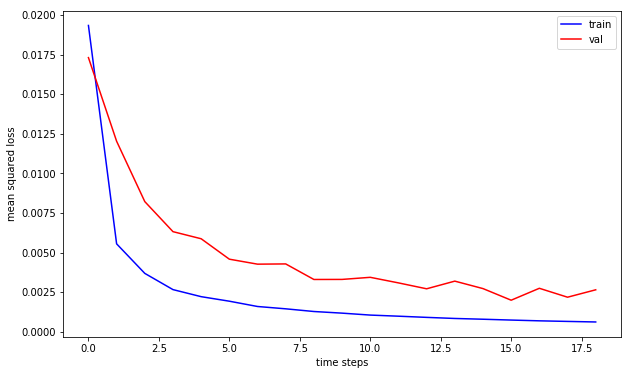

In [49]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='val')
plt.legend(loc='best')
plt.xlabel("time steps")
plt.ylabel("mean squared loss")
plt.show()

In [8]:
pred = model.predict(valX)

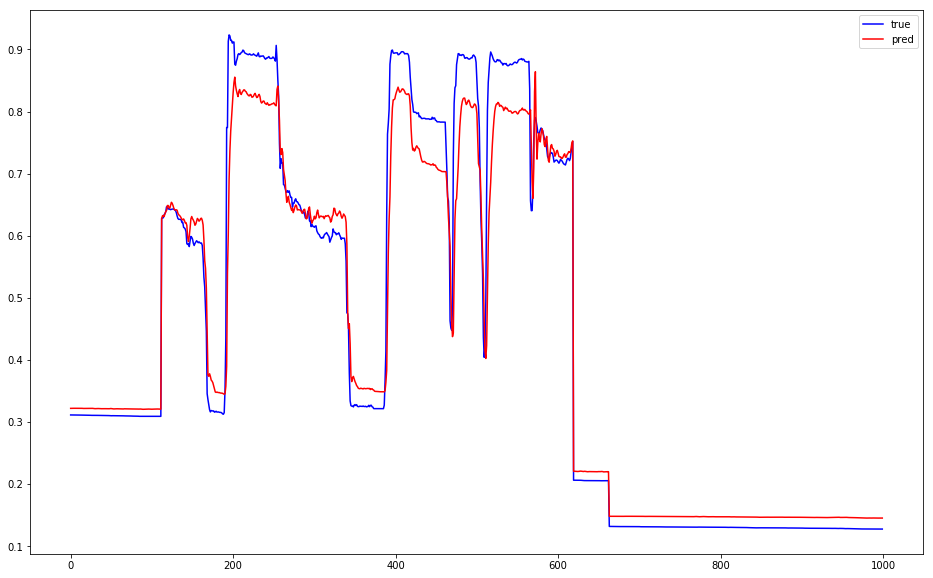

In [11]:
k = 0
s = 5000
e = 6000
true_ = valY[s:e, k]
pred_ = pred[s:e, k]
plt.figure(figsize=(16,10))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.show()

# try dynamic prediction

In [11]:
from keras.models import load_model

lookback = 10
hidden_neurons = 300
model = load_model('../LSTM_{}_{}.model'.format(lookback, hidden_neurons))

In [12]:
valX, valY = createDataset(val, lookback)

In [13]:
pred_sequence = []

val_brokens = getBrokens(val.index)
for i in range(len(val_brokens)-1):
    X_seq = val.iloc[val_brokens[i]:val_brokens[i]+lookback, :].values
    pred_sequence += list(X_seq)
    for j in range(val_brokens[i]+lookback, val_brokens[i+1]):
        predY = model.predict(np.array([X_seq]))[0]
        pred_sequence.append(predY)
        X_seq = np.concatenate((X_seq[1:], [predY]))
pred_sequence = np.array(pred_sequence)

In [22]:
def predictSequence(model, dataX, dataY, lookforward=1):
    dataX, dataY = np.array(dataX), np.array(dataY)
    
    X_ = dataX[:1-lookforward+len(dataX)].copy()
    for steps in range(lookforward):
        pred_ = model.predict(X_)
        pred_ = np.reshape(pred_, (pred_.shape[0], 1, pred_.shape[1]))
        X_ = np.concatenate((X_[:, 1:, :], pred_), axis=1)
    
    true_ = dataY[lookforward-1:]
    return true_, pred_[:, 0, :]

def predictSequenceTotal(model, dataset, lookforward=1):
    true_sequence, pred_sequence = [], []
    brokens = getBrokens(dataset.index)
    for i in range(len(brokens)-1):
        dataX, dataY = createSequnces(dataset.iloc[brokens[i]:brokens[i+1], :], lookback)
        t_s, p_s = predictSequence(model, dataX, dataY, lookforward)
        true_sequence.append(t_s)
        pred_sequence.append(p_s)
    return np.concatenate(true_sequence), np.concatenate(pred_sequence)

In [29]:
true_sequence, pred_sequence = predictSequenceTotal(model, val, 1)

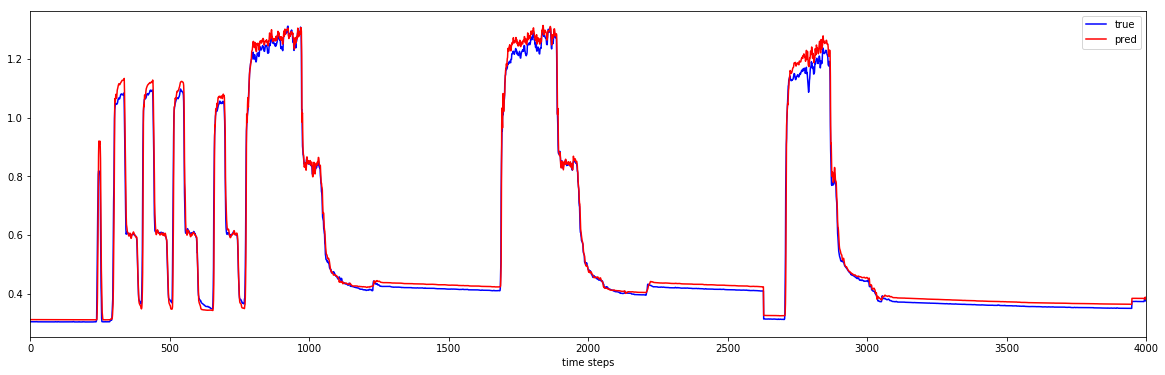

In [37]:
k = 2
s = 7000
e = 11000
true_ = true_sequence[s:e, k]
pred_ = pred_sequence[s:e, k]
plt.figure(figsize=(20,6))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.xlabel('time steps')
plt.xlim((0, 4000))
plt.show()

In [16]:
true_sequence, pred_sequence = predictSequenceTotal(model, val, 2)

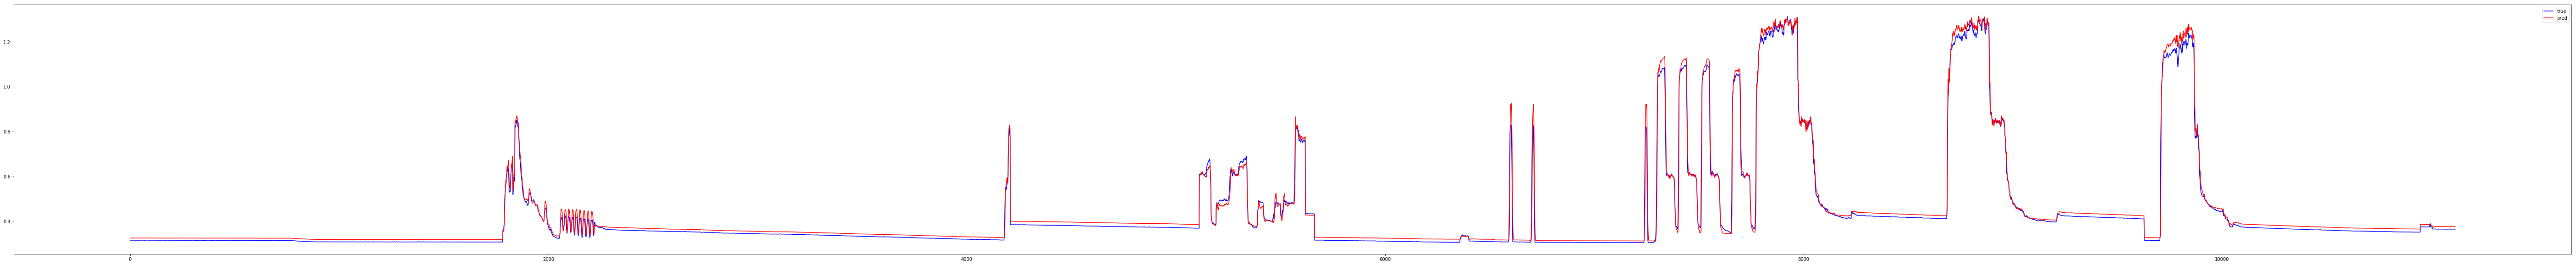

In [25]:
k = 2
s = 0
e = 25000
true_ = true_sequence[s:e, k]
pred_ = pred_sequence[s:e, k]
plt.figure(figsize=(100,10))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.show()

In [26]:
true_sequence, pred_sequence = predictSequenceTotal(model, val, 5)

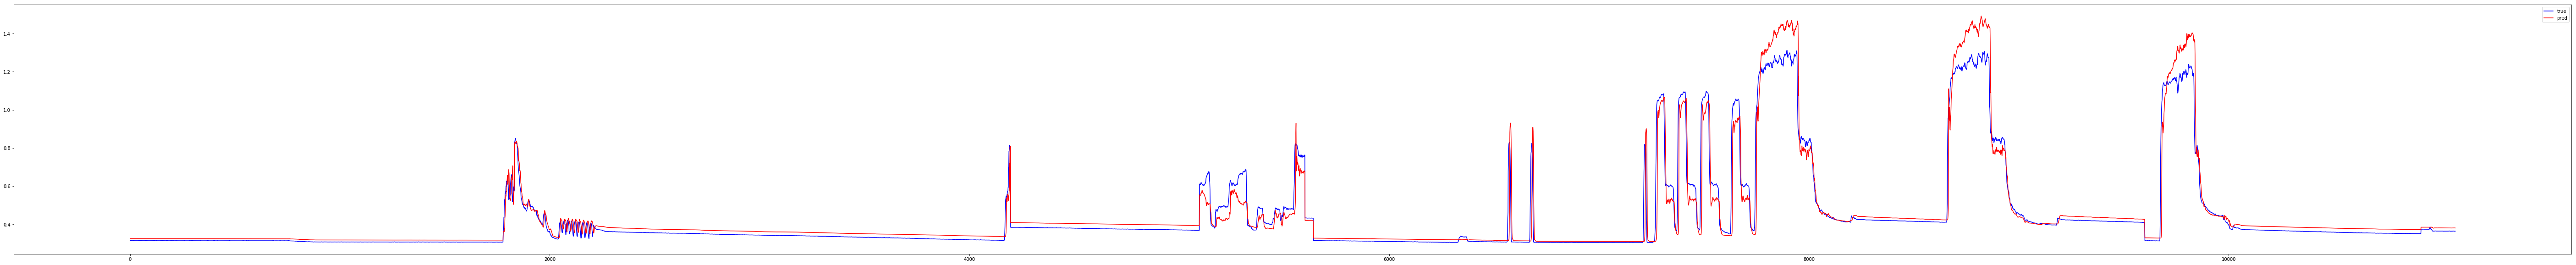

In [27]:
k = 2
s = 0
e = 25000
true_ = true_sequence[s:e, k]
pred_ = pred_sequence[s:e, k]
plt.figure(figsize=(100,10))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.show()

# plot abnormal

In [5]:
val2 = pd.read_csv('../val2_treated.csv', index_col=0)
vala = pd.read_csv('../vala_treated.csv', index_col=0)

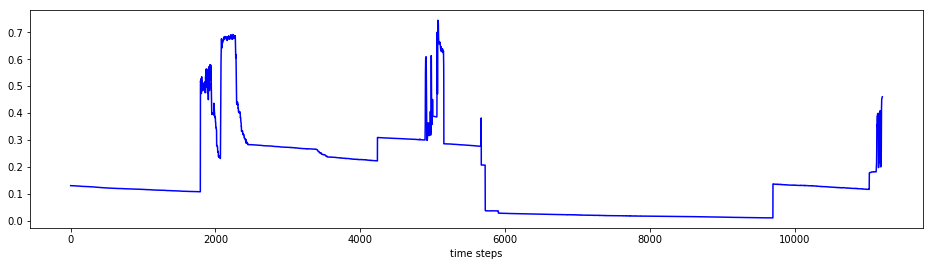

In [10]:
plt.figure(figsize=(16,4))
normal = val2.values[:, 0]
plt.plot(normal, color='b', label='normal') 
plt.xlabel('time steps')
plt.show()

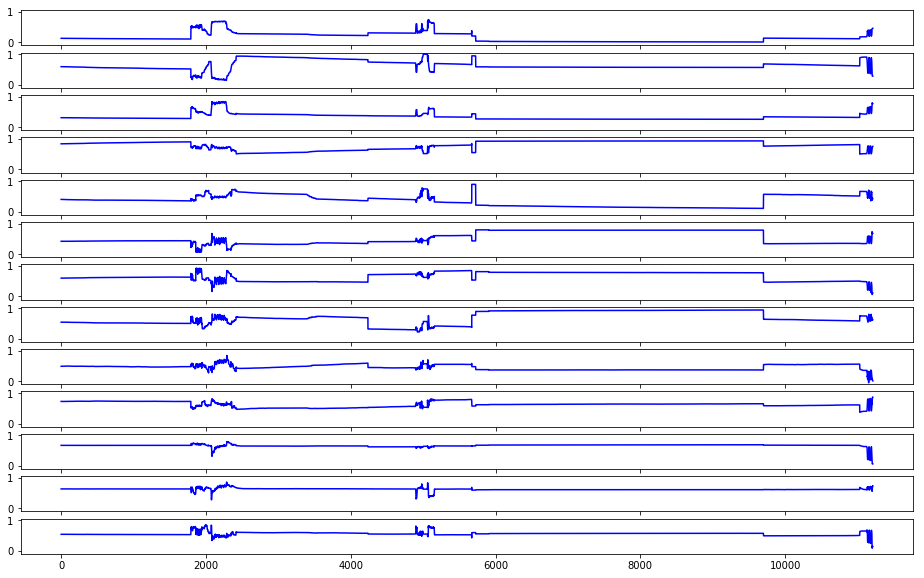

In [9]:
fig, axs = plt.subplots(nrows=13, ncols=1, sharex=True, sharey=True, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    normal = val2.values[:, i]
    ax.plot(normal, color='b', label='normal')   
plt.show()

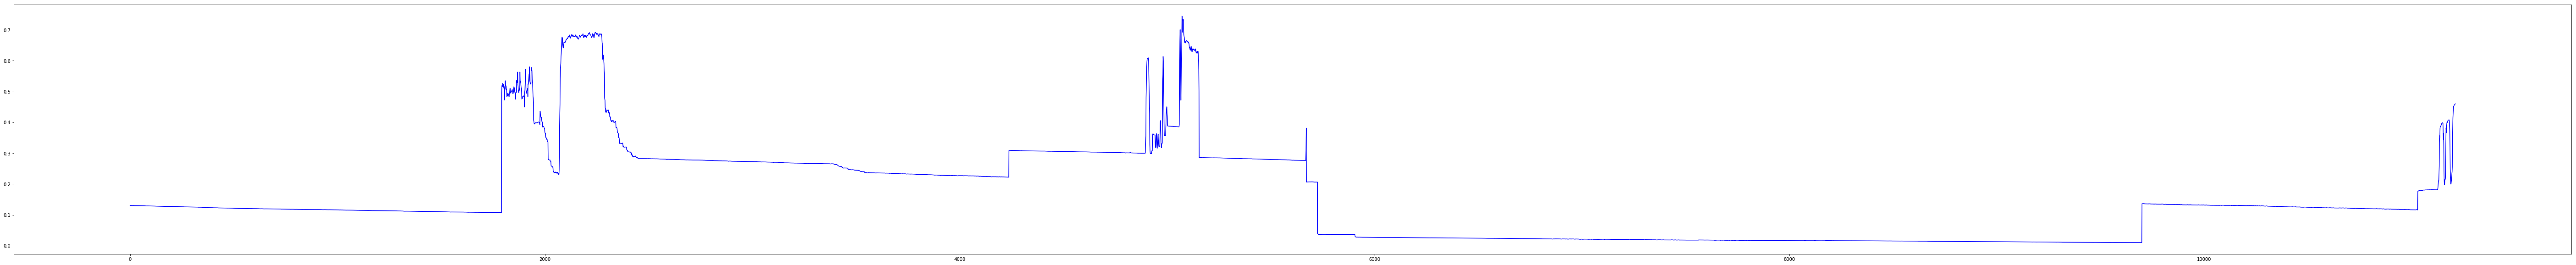

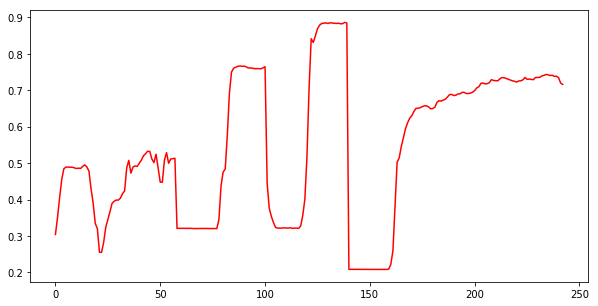

In [120]:
k = 0
normal = val2.values[:, k]
plt.figure(figsize=(100,10))
plt.plot(normal, color='b', label='normal')
plt.show()

abnormal = vala.values[:, k]
plt.figure(figsize=(10,5))
plt.plot(abnormal, color='r', label='abnormal')
plt.show()

# Simple method

In [74]:
from keras.models import load_model

lookback = 10
hidden_neurons = 300
model = load_model('../LSTM_{}_{}.model'.format(lookback, hidden_neurons))

In [75]:
def pointError(trueY, predY):
    trueY_ = np.array(trueY)
    predY_ = np.array(predY)
    rst = ((predY_ - trueY_) ** 2).mean(axis=1)
#     true_norm = (trueY_ ** 2).mean(axis=1)
    return rst

def windowAverage(errors, window=5):
    errors_ = np.array(errors)
    rst = [errors_[i:(i+window)].mean() for i in range(len(errors)-window+1)]
    return rst

In [76]:
val2 = pd.read_csv('../val2_treated.csv', index_col=0)
vala = pd.read_csv('../vala_treated.csv', index_col=0)

In [139]:
memory_width = 8

In [140]:
err_avg_n = []
val2_brokens = getBrokens(val2.index)
for i in range(len(val2_brokens)-1):
    val2X, val2Y = createSequnces(val2.iloc[val2_brokens[i]:val2_brokens[i+1], :], lookback)
    predY = model.predict(np.array(val2X))
    errors = pointError(val2Y, predY)
    err_avg_n += windowAverage(errors, memory_width)   

In [141]:
err_avg_a = []
vala_broken = getBrokens(vala.index)
for i in range(len(vala_broken)-1):
    valaX, valaY = createSequnces(vala.iloc[vala_broken[i]+20:vala_broken[i+1]-20, :], lookback)
    if len(valaY) == 0:
        continue
    predY = model.predict(np.array(valaX))
    errors = pointError(valaY, predY)
    err_avg_a += windowAverage(errors, memory_width)

In [142]:
value_label = np.array([[err, 0] for err in err_avg_n] + [[err, 1] for err in err_avg_a])
len(err_avg_n), len(err_avg_a), len(value_label)

(11059, 47, 11106)

In [143]:
def getOptimalFscore(value_label, beta=1):
    v_l_sorted = value_label[np.argsort(value_label[:, 0])[::-1]]
    p_best, r_best, f1_best, ts = 0, 0, 0, 0
    num_ones = sum(v_l_sorted[:, 1])
    count = 0
    for i, v in enumerate(v_l_sorted):
        if v[1] == 1.:
            count += 1
        p = count / (i+1)
        r = count / num_ones
        f1 = (1 + beta**2) * p * r / (beta**2 * p + r)        
        if f1 > f1_best:
            p_best = p
            r_best = r
            f1_best = f1
            ts = v[0]
    return p_best, r_best, f1_best, ts

In [144]:
getOptimalFscore(value_label)

(1.0, 0.9787234042553191, 0.989247311827957, 0.011185583423295987)

## simple method - search for optimal memory width

In [147]:
a = [[] for i in range(5)]
a[0] += [1,2,3]
a[2] += [6.7]
a

[[1, 2, 3], [], [6.7], [], []]

In [148]:
memory_widths = [3, 5, 8, 10]

err_avg_n = [[] for i in range(len(memory_widths))]
val2_brokens = getBrokens(val2.index)
for i in range(len(val2_brokens)-1):
    val2X, val2Y = createSequnces(val2.iloc[val2_brokens[i]:val2_brokens[i+1], :], lookback)
    predY = model.predict(np.array(val2X))
    errors = pointError(val2Y, predY)
    for j, memory_width in enumerate(memory_widths):
        err_avg_n[j] += windowAverage(errors, memory_width)

err_avg_a = [[] for i in range(len(memory_widths))]
vala_broken = getBrokens(vala.index)
for i in range(len(vala_broken)-1):
    valaX, valaY = createSequnces(vala.iloc[vala_broken[i]+20:vala_broken[i+1]-20, :], lookback)
    if len(valaY) == 0:
        continue
    predY = model.predict(np.array(valaX))
    errors = pointError(valaY, predY)
    for j, memory_width in enumerate(memory_widths):
        err_avg_a[j] += windowAverage(errors, memory_width)

In [149]:
bm = []
for i, memory_width in enumerate(memory_widths):
    value_label = np.array([[err, 0] for err in err_avg_n[i]] + [[err, 1] for err in err_avg_a[i]])
    p, r, f1, ts = getOptimalFscore(value_label, beta=1)
    bm.append( [memory_width, p, r, f1, ts])

bm = pd.DataFrame(bm, columns=['memory_width', 'precision', 'recall', 'f-score', 'threshold'])

In [150]:
bm

,memory_width,precision,recall,f-score,threshold
0,3,0.920000,0.807018,0.859813,0.013270
1,5,0.959184,0.886792,0.921569,0.011493
2,8,1.000000,0.978723,0.989247,0.011186
3,10,1.000000,1.000000,1.000000,0.012037


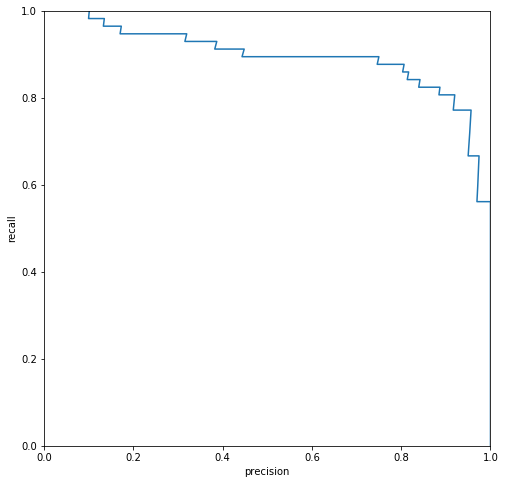

In [152]:
from sklearn.metrics import precision_recall_curve
i = 0

value_label = np.array([[err, 0] for err in err_avg_n[i]] + [[err, 1] for err in err_avg_a[i]])
p_trace, r_trace, _ = precision_recall_curve(value_label[:, 1], value_label[:, 0])

plt.figure(figsize=(8, 8))
plt.plot(p_trace, r_trace)
plt.xlabel('precision')
plt.ylabel('recall')
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

In [108]:
memory_width = 10
# lookback = 1
value_label = np.array([[err, 0] for err in err_avg_n[i]] + [[err, 1] for err in err_avg_a[i]])
p, r, f1, ts = getOptimalFscore(value_label, beta=1)
p, r, f1, ts

(0.9766081871345029,
 0.8882978723404256,
 0.9303621169916435,
 0.013228058077812323)

In [34]:
testn = pd.read_csv('../testn_treated.csv', index_col=0)
testa = pd.read_csv('../testa_treated.csv', index_col=0)

memory_width = 15

err_avg_test_n = []
testn_broken = getBrokens(testn.index)
for i in range(len(testn_broken)-1):
    testnX, testnY = createSequnces(testn.iloc[testn_broken[i]+20-lookback:testn_broken[i+1]-20, :], lookback)
    if len(testnY) == 0:
        continue
    predY_n = model.predict(np.array(testnX))
    errors_n = pointError(testnY, predY_n)
    err_avg_test_n += windowAverage(errors_n, memory_width)

err_avg_test_a = []
testa_broken = getBrokens(testa.index)
for i in range(len(testa_broken)-1):
    testaX, testaY = createSequnces(testa.iloc[testa_broken[i]+20-lookback:testa_broken[i+1]-20, :], lookback)
    if len(testaY) == 0:
        continue
    predY_a = model.predict(np.array(testaX))
    errors_a = pointError(testaY, predY_a)
    err_avg_test_a += windowAverage(errors_a, memory_width)

value_label_test = np.array([[err, 0, int(err >= ts)] for err in err_avg_test_n] + 
                            [[err, 1, int(err >= ts)] for err in err_avg_test_a])

In [35]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [36]:
confusion_matrix(value_label_test[:, 1], value_label_test[:, 2], labels=[1, 0])

array([[  49,    4],
       [  40, 6973]])

In [37]:
precision, recall, f1, _ = precision_recall_fscore_support(value_label_test[:, 1], 
                                                           value_label_test[:, 2], 
                                                           average='binary')
precision, recall, f1

(0.550561797752809, 0.9245283018867925, 0.6901408450704226)